In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

In [3]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [4]:
weather_forecast_data_1 = weather_forecast_data_1[weather_forecast_data_1['location'] != 'location']
weather_forecast_data_1['ts'] =  pd.to_datetime(weather_forecast_data_1['ts'], unit='s')
weather_forecast_data_1['base_ts'] = pd.to_datetime(weather_forecast_data_1['base_ts'], unit='s')

/tmp/ipykernel_807048/796732019.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_1['ts'] =  pd.to_datetime(weather_forecast_data_1['ts'], unit='s')
/tmp/ipykernel_807048/796732019.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_1['base_ts'] = pd.to_datetime(weather_forecast_data_1['base_ts'], unit='s')


In [5]:
# 평균을 구할 열 리스트
columns_to_average = [
    'temp', 'real_feel_temp', 'wet_bulb_temp', 'dew_point', 
    'wind_dir', 'wind_spd', 'wind_gust_spd', 'rel_hum', 'vis', 
    'ceiling', 'uv_idx', 'precip_prob', 'rain_prob', 'snow_prob', 
    'ice_prob', 'total_liq', 'rain', 'snow', 'ice', 'cld_cvr'
]

# 숫자형으로 변환할 수 있는 값만 변환
weather_forecast_data_1[columns_to_average] = weather_forecast_data_1[columns_to_average].apply(pd.to_numeric, errors='coerce')

In [6]:
# 'ts'로 그룹화하여 각 열의 평균 계산
average_df = weather_forecast_data_1.groupby('ts', as_index=False)[columns_to_average].mean()

In [7]:
weather_df = average_df

In [12]:
weather_df

,ts,temp,real_feel_temp,wet_bulb_temp,dew_point,wind_dir,wind_spd,wind_gust_spd,rel_hum,vis,...,uv_idx,precip_prob,rain_prob,snow_prob,ice_prob,total_liq,rain,snow,ice,cld_cvr
0,2024-03-01 15:00:00,1.728394,-4.320987,-0.555556,-4.320987,335.555556,22.048022,50.604944,64.333333,16.093400,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,75.555556
1,2024-03-01 16:00:00,1.851852,-4.506173,-0.432099,-4.135800,335.000000,22.048022,50.640711,64.333333,15.378140,...,0.0,14.000000,14.000000,2.222222,0.0,0.056444,0.056444,0.0,0.0,84.777778
2,2024-03-01 17:00:00,1.790123,-5.061728,-0.370370,-3.950616,334.444444,22.656000,51.481144,66.333333,14.392882,...,0.0,14.888889,14.888889,2.222222,0.0,0.197556,0.197556,0.0,0.0,89.333333
3,2024-03-01 18:00:00,1.604940,-5.308640,-0.370370,-3.888887,333.777778,23.263967,51.463267,67.333333,15.195758,...,0.0,14.444444,14.444444,2.222222,0.0,0.084667,0.084667,0.0,0.0,94.555556
4,2024-03-01 19:00:00,1.851852,-4.876541,-0.308642,-3.950616,333.888889,23.871922,50.837400,66.444444,15.825200,...,0.0,7.555556,7.555556,2.222222,0.0,0.000000,0.000000,0.0,0.0,82.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5660,2024-10-23 11:00:00,16.296289,14.074078,12.962967,10.061729,343.444444,18.757811,42.218444,66.555556,16.093400,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.222222
5661,2024-10-23 12:00:00,15.864200,13.765411,12.777767,10.000001,306.333333,18.561122,40.537589,67.888889,16.093400,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.111111
5662,2024-10-23 13:00:00,15.493833,13.209867,12.592589,9.814817,228.888889,17.094833,38.713678,69.888889,16.093400,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,14.222222
5663,2024-10-23 14:00:00,14.938256,12.777778,12.222233,9.814817,151.111111,16.290156,37.694422,72.333333,16.093400,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,9.111111


In [13]:
ahead_df = jeju_power_market_day_ahead

In [14]:
ahead_df['ts'] = pd.to_datetime(ahead_df['ts'], unit='s')

In [15]:
ahead_df

,ts,하루전가격(원/kWh)
0,2024-02-29 15:00:00,107.39
1,2024-02-29 16:00:00,107.39
2,2024-02-29 17:00:00,95.30
3,2024-02-29 18:00:00,87.89
4,2024-02-29 19:00:00,0.00
...,...,...
5660,2024-10-22 11:00:00,156.68
5661,2024-10-22 12:00:00,152.54
5662,2024-10-22 13:00:00,106.92
5663,2024-10-22 14:00:00,150.97


In [16]:
df = pd.merge(weather_df, ahead_df, on='ts')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ts              5641 non-null   datetime64[ns]
 1   temp            5641 non-null   float64       
 2   real_feel_temp  5641 non-null   float64       
 3   wet_bulb_temp   5641 non-null   float64       
 4   dew_point       5641 non-null   float64       
 5   wind_dir        5641 non-null   float64       
 6   wind_spd        5641 non-null   float64       
 7   wind_gust_spd   5641 non-null   float64       
 8   rel_hum         5641 non-null   float64       
 9   vis             5641 non-null   float64       
 10  ceiling         5641 non-null   float64       
 11  uv_idx          5641 non-null   float64       
 12  precip_prob     5641 non-null   float64       
 13  rain_prob       5641 non-null   float64       
 14  snow_prob       5641 non-null   float64       
 15  ice_

In [18]:
df['hour'] = df['ts'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month'] = df['ts'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_of_week'] = df['ts'].dt.dayofweek
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ts               5641 non-null   datetime64[ns]
 1   temp             5641 non-null   float64       
 2   real_feel_temp   5641 non-null   float64       
 3   wet_bulb_temp    5641 non-null   float64       
 4   dew_point        5641 non-null   float64       
 5   wind_dir         5641 non-null   float64       
 6   wind_spd         5641 non-null   float64       
 7   wind_gust_spd    5641 non-null   float64       
 8   rel_hum          5641 non-null   float64       
 9   vis              5641 non-null   float64       
 10  ceiling          5641 non-null   float64       
 11  uv_idx           5641 non-null   float64       
 12  precip_prob      5641 non-null   float64       
 13  rain_prob        5641 non-null   float64       
 14  snow_prob        5641 non-null   float64

In [20]:
df = df.drop(['ts', 'hour', 'month', 'day_of_week'], axis=1)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp             5641 non-null   float64
 1   real_feel_temp   5641 non-null   float64
 2   wet_bulb_temp    5641 non-null   float64
 3   dew_point        5641 non-null   float64
 4   wind_dir         5641 non-null   float64
 5   wind_spd         5641 non-null   float64
 6   wind_gust_spd    5641 non-null   float64
 7   rel_hum          5641 non-null   float64
 8   vis              5641 non-null   float64
 9   ceiling          5641 non-null   float64
 10  uv_idx           5641 non-null   float64
 11  precip_prob      5641 non-null   float64
 12  rain_prob        5641 non-null   float64
 13  snow_prob        5641 non-null   float64
 14  ice_prob         5641 non-null   float64
 15  total_liq        5641 non-null   float64
 16  rain             5641 non-null   float64
 17  snow          

In [22]:
df.rename(columns={
    '하루전가격(원/kWh)': 'previous_price_kwh'
}, inplace=True)

In [23]:
# df['previous_day_price'] = df['previous_price_kwh'].shift(24)
# df['previous_2day_price'] = df['previous_price_kwh'].shift(48)
# df['previous_3day_price'] = df['previous_price_kwh'].shift(72)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp                5641 non-null   float64
 1   real_feel_temp      5641 non-null   float64
 2   wet_bulb_temp       5641 non-null   float64
 3   dew_point           5641 non-null   float64
 4   wind_dir            5641 non-null   float64
 5   wind_spd            5641 non-null   float64
 6   wind_gust_spd       5641 non-null   float64
 7   rel_hum             5641 non-null   float64
 8   vis                 5641 non-null   float64
 9   ceiling             5641 non-null   float64
 10  uv_idx              5641 non-null   float64
 11  precip_prob         5641 non-null   float64
 12  rain_prob           5641 non-null   float64
 13  snow_prob           5641 non-null   float64
 14  ice_prob            5641 non-null   float64
 15  total_liq           5641 non-null   float64
 16  rain  

In [31]:
tmp_df = df.drop(['wind_dir', ], axis=1)

In [32]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

data = tmp_df[24*3:]

# 80%까지는 훈련 데이터로, 20%는 테스트 데이터로 사용
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

X_train, y_train = train.drop(['previous_price_kwh'], axis=1), train['previous_price_kwh']
X_test, y_test = test.drop(['previous_price_kwh'], axis=1), test['previous_price_kwh']

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# 모델 학습
model = LGBMRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 예측
y_pred = model.predict(X_test_scaled)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3326
[LightGBM] [Info] Number of data points in the train set: 4455, number of used features: 21
[LightGBM] [Info] Start training from score 127.402233
Mean Squared Error (MSE): 563.2141987972859
Mean Absolute Error (MAE): 17.24432599085806
Root Mean Squared Error (RMSE): 23.73213430766997


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 파라미터 범위 설정
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# 모델과 RandomizedSearchCV 설정
model = LGBMRegressor(random_state=42, device='gpu', gpu_platform_id=0, gpu_device_id=0)
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, 
    n_iter=100, scoring='neg_mean_absolute_error', 
    cv=5, random_state=42, n_jobs=-1
)

# 학습
random_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 3564, number of used features: 21
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3285
[LightGBM] [Info] Number of data points in the train set: 3564, number of used features: 21
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3253
[LightGBM] [Info] Number of data points in the train set: 3564, number of used features: 21
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3306
[LightGBM] [Info] Number of data points in the train set: 3564, number of used features: 21
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 328

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f6d0ce58670>
Traceback (most recent call last):
  File "/home/jinjinjara1022/.local/lib/python3.10/site-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


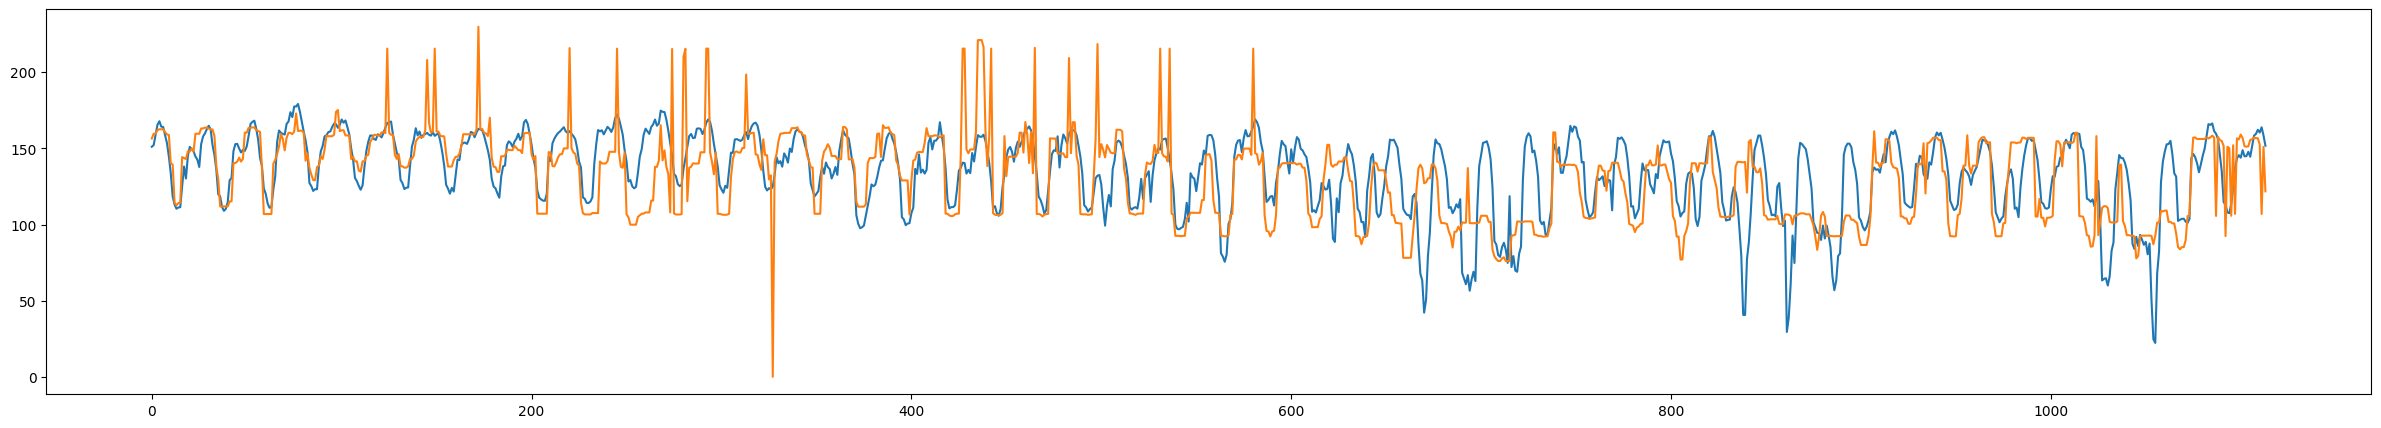

In [34]:
plt.figure(figsize=(30, 5))

plt.plot(y_pred)
plt.plot(y_test.to_numpy())
plt.show()

In [35]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

import xgboost as xgb
print(xgb.__version__)

2.1.1


In [36]:
SMAPE(y_test, y_pred)

7.020323044078491

In [30]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

            feature  importance
4          wind_dir         264
7           rel_hum         259
3         dew_point         226
1    real_feel_temp         224
5          wind_spd         219
19          cld_cvr         218
0              temp         202
6     wind_gust_spd         197
10           uv_idx         183
20         hour_sin         171
2     wet_bulb_temp         132
21         hour_cos         110
11      precip_prob         100
24  day_of_week_sin          96
9           ceiling          94
8               vis          81
25  day_of_week_cos          75
22        month_sin          66
23        month_cos          58
15        total_liq          25
17             snow           0
13        snow_prob           0
12        rain_prob           0
16             rain           0
14         ice_prob           0
18              ice           0


In [31]:
y = df['previous_price_kwh']
x = df.drop(['previous_price_kwh'], axis=1)

In [32]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = int(len(y) * 0.1))
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

train data shape
x:(5077, 29), y:(5077,)


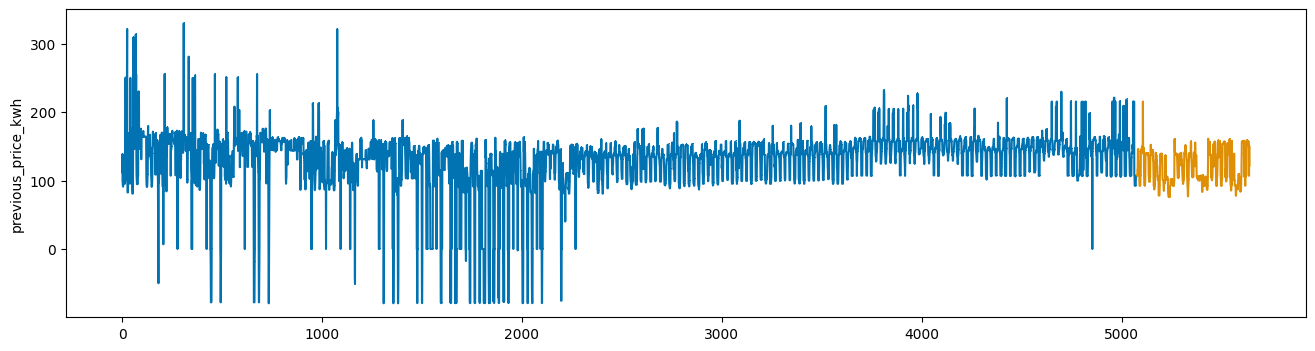

In [33]:
plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [35]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=4000,
    learning_rate=0.001, 
    min_child_weight=0.5,
    max_depth=8,
    colsample_bytree=0.8,
    subsample=0.8,
    tree_method='hist',
    device='cuda',
    seed=0,
    early_stopping_rounds=500 
)

xgb_reg.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

/home/jinjinjara1022/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:38:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


SMAPE : 5.439583718079589


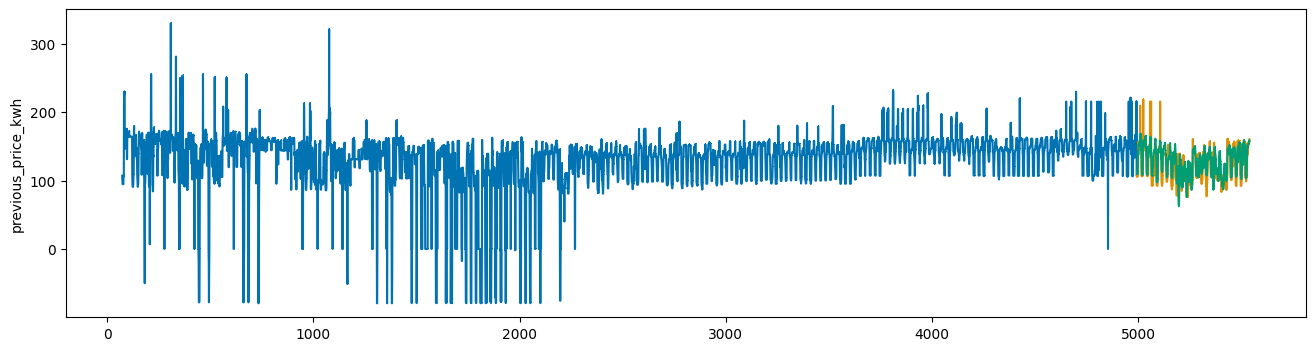

In [128]:
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

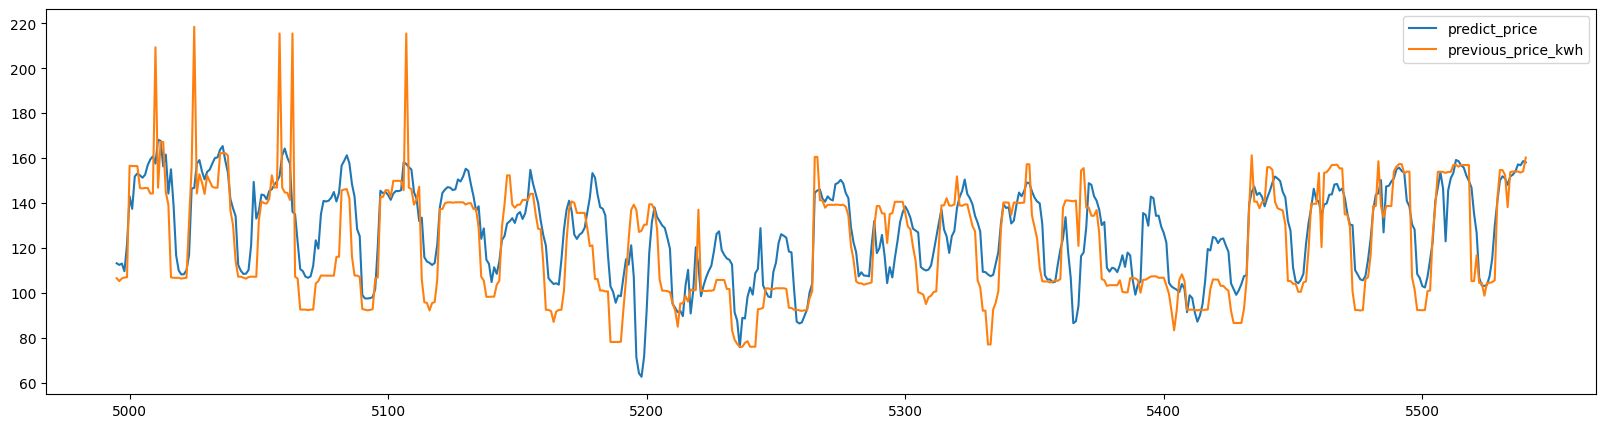

In [129]:
plt.figure(figsize=(20, 5))
pred.plot(label='predict_price')
y_valid.plot()
plt.legend()
plt.show()